In [2]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from jiwer import wer
from datasets import load_dataset
import librosa
import soundfile as sf
from datasets import load_metric

In [1]:
%pip install jiwer datasets transformers[torch]
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


In [5]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# directory with the Common Voice dataset
CV_DIRECTORY = '/content'

# Load metadata
cv_df = pd.read_csv(os.path.join(CV_DIRECTORY, 'cv-valid-train.csv'))

# Load audio data as a dataset
data_files = [os.path.join(CV_DIRECTORY, "cv-valid-train", filename) for filename in cv_df["filename"]]
cv_dataset = load_dataset("audiofolder", data_files=data_files, drop_metadata=True)["train"]


Resolving data files:   0%|          | 0/195776 [00:00<?, ?it/s]

In [8]:
cv_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [9]:
# Adding additional columns
cv_dataset = cv_dataset.add_column("file", cv_df["filename"])
cv_dataset = cv_dataset.add_column("text", cv_df["text"])
cv_dataset = cv_dataset.add_column("up_votes", cv_df["up_votes"])
cv_dataset = cv_dataset.add_column("down_votes", cv_df["down_votes"])

In [11]:
print(cv_dataset)
print("File:        {}".format(cv_dataset[0]["file"]))
print("Audio:       {}".format(cv_dataset[0]["audio"]))
print("Text:        {}".format(cv_dataset[0]["text"]))
print("Upvotes:     {}".format(cv_dataset[0]["up_votes"]))
print("Downvotes:   {}".format(cv_dataset[0]["down_votes"]))

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 195776
})
File:        cv-valid-train/sample-000000.mp3
Audio:       {'path': '/content/cv-valid-train/cv-valid-train/sample-000000.mp3', 'array': array([ 0.00000000e+00, -2.39675413e-13, -2.89491331e-14, ...,
        4.10622597e-04,  7.94679159e-04,  7.57522532e-04]), 'sampling_rate': 48000}
Text:        learn to recognize omens and follow them the old king had said
Upvotes:     1
Downvotes:   0


## Preprocess Data

For preprocessing, we start by calculating the durations of the audio samples in the dataset.

In [11]:
# for each audio sample, calculate the duration
# add the duration into a dictionary
durations = {}

def get_duration(batch):
    duration = len(batch["audio"]["array"]) // batch["audio"]["sampling_rate"]
    durations[duration] = durations.get(duration, 0) + 1

cv_dataset.map(get_duration)

Map:   0%|          | 0/195776 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 195776
})

In [12]:
# Create a histogram of durations
max_duration = max(durations.keys())
histogram = [0] * (max_duration + 1)
for duration, count in durations.items():
    histogram[duration] = count

In [13]:
# Calculate cumulative sum to find cutoff
cumsum = np.cumsum(histogram)
total_samples = cumsum[-1]
cutoff_duration = next(i for i, total in enumerate(cumsum) if total >= total_samples * 0.5)


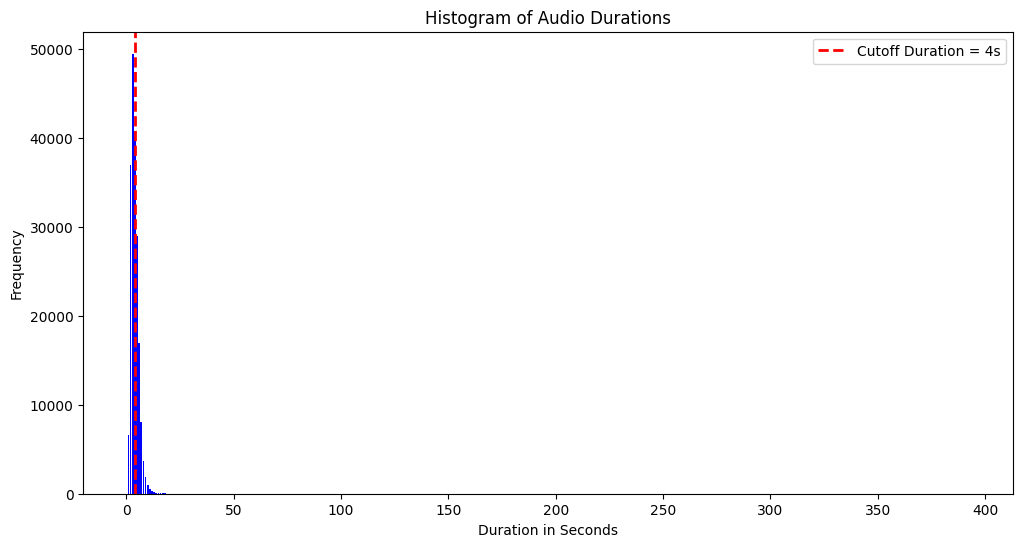

Cutoff duration to keep 50% of the samples: 4 seconds


In [15]:
# Plot the histogram of audio durations
plt.figure(figsize=(12, 6))
plt.bar(range(len(histogram)), histogram, color='blue')
plt.title('Histogram of Audio Durations')
plt.xlabel('Duration in Seconds')
plt.ylabel('Frequency')
plt.axvline(x=cutoff_duration, color='r', linestyle='dashed', linewidth=2, label=f'Cutoff Duration = {cutoff_duration}s')
plt.legend()
plt.show()

print(f"Cutoff duration to keep 50% of the samples: {cutoff_duration} seconds")

Next step of preprocessing is to filter the dataset to make it more optimal for training.

1. We filter out data with duration longer than the cutoff duration calculated.

2. We filter out data samples with number of downvotes more than 10% of number of upvotes.

3. We filter out data samples with 0 upvotes.

In doing so, we can filter out poorer quality data samples.

In [14]:
# Filtering the dataset based on duration and votes

def filter_samples(batch):
    return (len(batch["audio"]["array"])//batch["audio"]["sampling_rate"]<=cutoff_duration and
            batch["down_votes"] < 0.1 * batch["up_votes"] and
            batch["up_votes"] >=1)

filtered_dataset = cv_dataset.filter(filter_samples)


In [17]:
print(filtered_dataset)

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 122608
})


When analysing the data transcriptions, there are some special characters, which may make it more complicated for the model during training.

The special characters are removed from the dataset and the text is normalised to be lower case.


In [15]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).upper()
    return batch
filtered_dataset = filtered_dataset.map(remove_special_characters)

As the dataset has a sampling rate of 48000, but the model requires a sampling rate of 16000, we resample the data to adjust the sampling rate.

In [16]:
from datasets import Audio

# Adjust the sampling rate to 16000
clean_filtered_dataset = filtered_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [17]:
# Split the dataset into training and validation sets (70-30 split)

# Due to GPU constraints, training of the model was unable to be sustained for multiple hours, so the dataset was further split to reduce dataset size.
# For better results, just perform train_test_split on the full filtered dataset.
# cv_dataset = clean_filtered_dataset.train_test_split(test_size=0.30)
cv_dataset = clean_filtered_dataset.train_test_split(test_size=0.1)['test']
cv_dataset = cv_dataset.train_test_split(test_size=0.30)

In [21]:
print(cv_dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
        num_rows: 8582
    })
    test: Dataset({
        features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
        num_rows: 3679
    })
})


In [18]:
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

print("Total number of samples: {}".format(sum(cv_dataset.num_rows.values())))
show_random_elements(cv_dataset["train"].remove_columns([f for f in cv_dataset["train"].features if f != "text"]))

Total number of samples: 12261


,text
0,HE WANTED TO SAY SO TO THE ALCHEMIST BUT HE WAS AFRAID OF THE MAN
1,SHE JUST CALLED ME
2,HE'S IN MY ROOM
3,IF YOU DON'T STOP FOLLOWING ME I'LL CALL THE POLICE
4,AND HE KNEW WHAT WAS THE FAIR PRICE FOR EVERY ONE OF HIS ANIMALS
5,A WHILE AGO I RODE THROUGH THE DESERT WITH A MAN WHO HAD BOOKS ON ALCHEMY
6,HE COULD ALWAYS GO BACK TO BEING A SHEPHERD
7,THE INTERNATIONAL SPACE STATION IS AN AWESOME PROJECT
8,MOST OF THEM WERE STARING QUIETLY AT THE BIG TABLE
9,BECAUSE HE KNEW WHAT HE WOULD FIND


In [23]:
import IPython.display as ipd
import numpy as np
import random

data_split = ["train", "test"]

rand_split = random.choice(data_split)
rand_int = random.randint(0, len(cv_dataset[rand_split]))

print("Data split:          {}".format(rand_split))
print("File:                {}".format(cv_dataset[rand_split][rand_int]["file"]))
print("Audio:               {}".format(cv_dataset[rand_split][rand_int]["audio"]))
print("Target Text:         {}".format(cv_dataset[rand_split][rand_int]["text"]))
print("Input array shape:   {}".format(np.asarray(cv_dataset[rand_split][rand_int]["audio"]["array"]).shape))
print("Sampling rate:       {}".format(cv_dataset[rand_split][rand_int]["audio"]["sampling_rate"]))
ipd.Audio(data=np.asarray(cv_dataset[rand_split][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

Data split:          test
File:                cv-valid-train/sample-105302.mp3
Audio:               {'path': '/content/cv-valid-train/cv-valid-train/sample-105302.mp3', 'array': array([ 1.03397577e-25,  3.48966821e-25,  2.19719850e-24, ...,
        9.32469266e-06, -9.75314470e-06, -2.61658279e-05]), 'sampling_rate': 16000}
Target Text:         AUGUST MAY HAVE ENDED EARLY
Input array shape:   (46848,)
Sampling rate:       16000


For the last part of preprocessing, we extract input values and labels from the audio files.

This will generate dataset ready for training.

In [19]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

SAMPLING_RATE = processor.feature_extractor.sampling_rate

In [20]:
# Prepare the dataset to train the model by processing the audio and text into input values and labels
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio=audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["labels"] = processor(text=batch["text"]).input_ids

    return batch

cv_data = cv_dataset.map(prepare_dataset, remove_columns=cv_dataset.column_names["train"])
print(cv_data)

Map:   0%|          | 0/8582 [00:00<?, ? examples/s]

Map:   0%|          | 0/3679 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 8582
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 3679
    })
})


## Training and Evaluation

Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, a collator dataclass is defined below.

In [21]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

# Collator dataclass to pad the input values and labels so that the data can be of uniform size when they are passed into the model.
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [22]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

For evaluation, we use the word error rate (WER) metrics. Word error rate is the number of errors divided by the total number of words. WER is a common metric used to measure the accuracy of ASR systems. 

In [23]:
wer_metric = load_metric("wer")
# Create the compute metrics function to evaluate the model during the finetuning process
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

<ipython-input-23-910f9a62807f>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Load a pretrained model and then define the training configuration.

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained and as stated in the paper does not need to be fine-tuned anymore.

In [30]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# freezing the first component of Wav2Vec2
model.freeze_feature_extractor()

OUTPUT_DIR = '/content/results'

# To save GPU memory, enable PyTorch's gradient checkpointing
training_args = TrainingArguments(
  output_dir=OUTPUT_DIR,
  group_by_length=True, # batches of similar lengths are grouped together, makes training more efficient
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  gradient_accumulation_steps=4,  # increase by 2x for every 2x decrease in batch size
  eval_accumulation_steps=4,
  evaluation_strategy="steps", # perform evaluation at regular intervals based on number of steps
  num_train_epochs=5,
  fp16=True, # 16-bit floating point precision
  gradient_checkpointing=True,
  save_steps=200,
  eval_steps=200,
  logging_steps=200,
  learning_rate=1e-4, # a moderate learning rate chosen to balance between training speed and stability
  weight_decay=0.005, # for regularisation, penalise larger weights to have a more generatlised model
  warmup_steps=100, # number of steps to increase the LR from zero to specified learning rate
  save_total_limit=2,
  push_to_hub=False,
)

training_args

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=4,
eval_delay=0,
eval_steps=200,
evaluation_strategy=steps,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer

In [100]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=cv_data["train"],
    eval_dataset=cv_data["test"],
    tokenizer=processor.feature_extractor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [32]:
# start training
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
200,181.371600,87.479324,0.146495
400,132.637100,64.997551,0.109235
600,112.472300,63.858124,0.102118
800,98.618300,57.789761,0.089523
1000,82.925300,53.333359,0.084743
1200,72.171500,49.309696,0.078394


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tran

TrainOutput(global_step=1340, training_loss=108.44153961637127, metrics={'train_runtime': 2874.4245, 'train_samples_per_second': 14.928, 'train_steps_per_second': 0.466, 'total_flos': 4.4370829842802606e+18, 'train_loss': 108.44153961637127, 'epoch': 5.0})

In [33]:
import pandas as pd
loss_df = pd.DataFrame(trainer.state.log_history)
trainloss_df = loss_df.dropna(axis=0, subset="loss")
evalloss_df = loss_df.dropna(axis=0, subset="eval_loss")

In [34]:
trainloss_df
trainloss_df.to_csv('train_loss.csv', index=False)

In [35]:
evalloss_df
evalloss_df.to_csv('test_loss.csv', index=False)

In [36]:
# save model
trainer.save_model("wav2vec2-large-960h-cv")

In [38]:
trainloss_df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,181.3716,2481.951660,0.000093,0.75,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132.6371,1739.435425,0.000077,1.49,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112.4723,6864.836426,0.000061,2.24,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,98.6183,2252.436523,0.000044,2.98,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,82.9253,3830.888916,0.000028,3.73,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,72.1715,950.786316,0.000012,4.47,1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
evalloss_df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,NaN,NaN,NaN,0.75,200,87.479324,0.146495,132.0931,27.852,3.482,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.49,400,64.997551,0.109235,131.9832,27.875,3.485,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,2.24,600,63.858124,0.102118,133.1161,27.638,3.456,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,2.98,800,57.789761,0.089523,133.5022,27.558,3.446,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,3.73,1000,53.333359,0.084743,131.1671,28.048,3.507,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,4.47,1200,49.309696,0.078394,131.7299,27.928,3.492,NaN,NaN,NaN,NaN,NaN


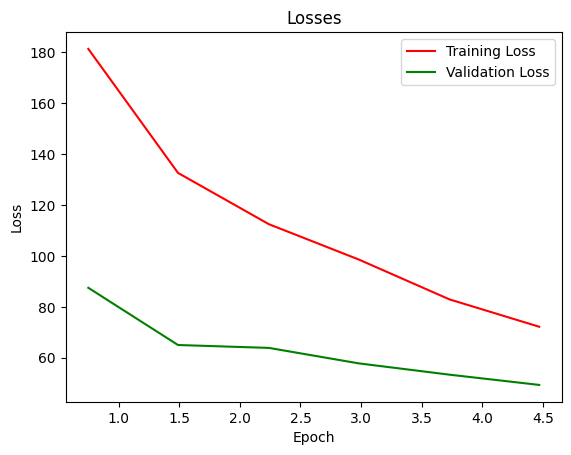

In [40]:
import matplotlib.pyplot as plt

plt.plot(trainloss_df["epoch"], trainloss_df["loss"], color='r', label='Training Loss')
plt.plot(evalloss_df["epoch"], evalloss_df["eval_loss"], color='g', label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses")

plt.legend()

plt.show()

It can be observed that both the training and validation losses decrease over epochs, indicating that the model is learning and improving its predictions over time. As the validation loss is still decreasing during the last epoch, the model could potentially be trained for more epochs.  

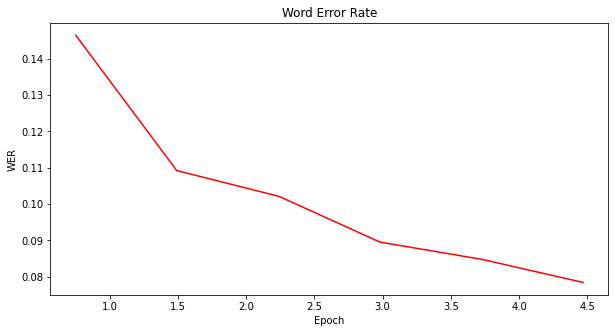

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(evalloss_df["epoch"], evalloss_df["eval_wer"], color='r', label='Word Error Rate')

plt.xlabel("Epoch")
plt.ylabel("WER")
plt.title("Word Error Rate")

plt.show()

From the plot of word error rate (WER) against epoch, we observe that the WER shows significant decrease over the 5 epochs. The gradient becomes less steep as the number of epochs increases, indicating that the model's learning is stabilising and beginning to converge towards its best performance on the training data. 

### Task 3C

Use fine-tuned AI model to transcribe the common-voice mp3 files under cv-valid-test and compare the generated text against cv-valid-test.csv. Log your overall performance.

In [41]:
# Load cv-valid-test into a pandas dataframe
cv_val_test_df = pd.read_csv(os.path.join(CV_DIRECTORY, 'cv-valid-test.csv'))

cv_val_test_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...,2,0,NaN,NaN,NaN,NaN


In [42]:
from datasets import load_dataset

# Load the cv-valid-test dataset
# update CV_DIRECTORY accordingly
data_files = [os.path.join(CV_DIRECTORY, "cv-valid-test", filename) for filename in cv_val_test_df["filename"]]

cv_val_dataset = load_dataset("audiofolder", data_files=data_files, drop_metadata=True)

cv_val_dataset = cv_val_dataset["train"]

# same as the train dataset, add information about the data to do preprocessing later
cv_val_dataset = cv_val_dataset.add_column("file", cv_val_test_df["filename"])
cv_val_dataset = cv_val_dataset.add_column("text", cv_val_test_df["text"])
cv_val_dataset = cv_val_dataset.add_column("up_votes", cv_val_test_df["up_votes"])
cv_val_dataset = cv_val_dataset.add_column("down_votes", cv_val_test_df["down_votes"])

print(cv_val_dataset)

Resolving data files:   0%|          | 0/3995 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 3995
})


In [43]:
# preprocessing of the test data

# Remove special characters
cv_val_ds = cv_val_dataset.map(remove_special_characters)

# Adjust sampling rate from 48000 to 16000
cv_eval_ds = cv_val_ds.cast_column("audio", Audio(sampling_rate=16000))

# Extract the input values and the labels for Evaluation on the model
processed_val_data = cv_eval_ds.map(prepare_dataset)

print(processed_val_data)

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes', 'input_values', 'labels'],
    num_rows: 3995
})


In [102]:
# Predict the transcription of every test sample
# Save the prediction in the dataset itself

def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device=device).unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

# Generate the resulting dictionary
results = processed_val_data.map(map_to_result)

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [103]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.179


We observe that the test word error rate is much higher than the validation word error rate obtained at the end of training. It could be due to the model not being trained on sufficient data (due to GPU constraints) or sufficient number of epochs (due to GPU constraints as well). It could also be because the test dataset was not filtered to remove poorer quality data and longer duration data.

In [76]:
# Save the predicted text to CSV
cv_val_test_df["generated_text"] = results["pred_str"]
cv_val_test_df.to_csv("cv-valid-test.csv", index=False)

In [80]:
print(results)

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes', 'input_values', 'labels', 'pred_str'],
    num_rows: 3995
})


In [77]:
# we can visualise the testing results

from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [78]:
show_random_elements(results)

,audio,file,text,up_votes,down_votes,input_values,labels,pred_str
0,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...], 'sampling_rate': 16000}",cv-valid-test/sample-002619.mp3,EVERYTHING HAS BEEN WRITTEN BY THE SAME HAND,3,0,"[-0.002055459190160036, -0.0020554587244987488, -0.0020554596558213234, -0.0020554603543132544, -0.0020554601214826107, -0.002055458491668105, -0.0020554594229906797, -0.0020554589573293924, -0.002055458026006818, -0.002055458026006818, -0.002055458491668105, -0.0020554594229906797, -0.002055458026006818, -0.0020554587244987488, -0.002055458491668105, -0.0020554617512971163, -0.0020554587244987488, -0.0020554603543132544, -0.0020554608199745417, -0.00205546198412776, -0.0020554610528051853, -0.002055462682619691, -0.0020554603543132544, -0.002055463846772909, -0.00205546198412776, -0.0020554610528051853, -0.0020554608199745417, -0.0020554601214826107, -0.0020554622169584036, -0.0020554617512971163, -0.0020554608199745417, -0.0020554643124341965, -0.0020554601214826107, -0.0020554594229906797, -0.0020554603543132544, -0.0020554622169584036, -0.0020554615184664726, -0.00205546198412776, -0.0020554608199745417, -0.0020554615184664726, -0.002055461285635829, -0.0020554608199745417, -0.002055460587143898, -0.002055459888651967, -0.0020554622169584036, -0.0020554587244987488, -0.002055458026006818, -0.0020554603543132544, -0.002055458026006818, -0.0020554608199745417, -0.002055459190160036, -0.0020554587244987488, -0.0020554594229906797, -0.002055456629022956, -0.0020554594229906797, -0.0020554603543132544, -0.0020554594229906797, -0.0020554587244987488, -0.0020554603543132544, -0.0020554547663778067, -0.002055457094684243, -0.0020554594229906797, -0.002055458026006818, -0.0020554587244987488, -0.0020554587244987488, -0.0020554587244987488, -0.0020554603543132544, -0.0020554563961923122, -0.0020554603543132544, -0.002055458026006818, -0.0020554587244987488, -0.0020554587244987488, -0.0020554587244987488, -0.0020554608199745417, -0.002055458026006818, -0.002055456629022956, -0.0020554594229906797, -0.0020554594229906797, -0.0020554596558213234, -0.0020554589573293924, -0.002055456629022956, -0.002055457327514887, -0.0020554575603455305, -0.002055459190160036, -0.0020554596558213234, -0.002055458491668105, -0.0020554615184664726, -0.002055461285635829, -0.002055458026006818, -0.0020554608199745417, -0.0020554587244987488, -0.002055457793176174, -0.0020554601214826107, -0.0020554561633616686, -0.002055458026006818, -0.0020554594229906797, -0.0020554594229906797, -0.002055457327514887, -0.002055458026006818, -0.0020554575603455305, ...]","[5, 25, 5, 13, 22, 6, 11, 10, 9, 21, 4, 11, 7, 12, 4, 24, 5, 5, 9, 4, 18, 13, 10, 6, 6, 5, 9, 4, 24, 22, 4, 6, 11, 5, 4, 12, 7, 17, 5, 4, 11, 7, 9, 14]",EVERYTHING HAD BEN WRITTEN BY THE SAME HND
1,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578125e-05, -3.0517578125e-05, 0.0, 0.0, -3.0517578125e-05, 0.0, 0.0, -3.0517578125e-05, 0.0, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, 0.0, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, 0.0, -3.0517578125e-05, 0.0, 0.0, -3.0517578125e-05, 0.0, 0.0, -3.0517578125e-05, -3.0517578125e-05, 0.0, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, -3.0517578125e-05, 0.0, -3.0517578125e-05, -3.0517578125e-05, -3

## Task 4

### Compare model with cv-valid-dev dataset

The code below is used to compare finetuned model from task 3 to results from task 2a and generate the results in training-report.pdf.

In [158]:
CV_DATASET = "cv-valid-dev"

cv_dev_metadata = pd.read_csv(os.path.join(CV_DIRECTORY, CV_DATASET + '.csv'))
#cv_dev_metadata["generated_text"] = cv_dev_metadata["generated_text"].astype(str)

cv_dev_metadata.head(5)

,,,,,,,,cv-valid-dev-updated
filename,text,up_votes,down_votes,age,gender,accent,duration,generated_text
cv-valid-dev/sample-000000.mp3,be careful with your prognostications said the stranger,1,0,NaN,NaN,NaN,NaN,BE CAREFUL WITH YOUR PROGNOSTICATIONS SAID THE...
cv-valid-dev/sample-000001.mp3,then why should they be surprised when they see one,2,0,NaN,NaN,NaN,NaN,THEN WHY SHOULD THEY BE SURPRISED WHEN THEY SE...
cv-valid-dev/sample-000002.mp3,a young arab also loaded down with baggage entered and greeted the englishman,2,0,NaN,NaN,NaN,NaN,A YOUNG ARAB ALSO LOADED DOWN WITH BAGGAGE ENT...
cv-valid-dev/sample-000003.mp3,i thought that everything i owned would be destroyed,3,0,NaN,NaN,NaN,NaN,I FELT THAT EVERYTHING I OWNED WOULD BE DESTROYED


In [108]:
MODEL_FOLDER = "/content/wav2vec2-large-960h-cv"

# load the finetuned model to evaluate on the dataset
finetuned_model = Wav2Vec2ForCTC.from_pretrained(MODEL_FOLDER)
finetuned_model.to(device)


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder

In [165]:
# use the finetuned model to test
# load dataset first

# directory with the Common Voice dataset
CV_DIRECTORY = '/content'

# Load metadata
cv_dev_metadata = pd.read_csv(os.path.join(CV_DIRECTORY, 'cv-valid-dev.csv'))

# Load audio data as a dataset
data_files = [os.path.join(CV_DIRECTORY, "cv-valid-dev", filename) for filename in cv_df["filename"]]
cv_dev_dataset = load_dataset("audiofolder", data_files=data_files, drop_metadata=True)["train"]


Resolving data files:   0%|          | 0/4076 [00:00<?, ?it/s]

In [164]:
print(cv_dev_dataset)

Dataset({
    features: ['audio'],
    num_rows: 4076
})


In [166]:
cv_dev_dataset = cv_dev_dataset.add_column("file", cv_dev_metadata["filename"])
cv_dev_dataset = cv_dev_dataset.add_column("text", cv_dev_metadata["text"])
cv_dev_dataset = cv_dev_dataset.add_column("up_votes", cv_dev_metadata["up_votes"])
cv_dev_dataset = cv_dev_dataset.add_column("down_votes", cv_dev_metadata["down_votes"])
cv_dev_dataset = cv_dev_dataset.add_column("pretrained_text", cv_dev_metadata["generated_text"])



In [167]:
print(cv_dev_dataset)
print("File:            {}".format(cv_dev_dataset[10]["file"]))
print("Audio Path:      {}".format(cv_dev_dataset[10]["audio"]))
print("Text:            {}".format(cv_dev_dataset[10]["text"]))
print("Pretrained Text: {}".format(cv_dev_dataset[10]["pretrained_text"]))
print("Upvotes:         {}".format(cv_dev_dataset[10]["up_votes"]))
print("Downvotes:       {}".format(cv_dev_dataset[10]["down_votes"]))

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes', 'pretrained_text'],
    num_rows: 4076
})
File:            cv-valid-dev/sample-000010.mp3
Audio Path:      {'path': '/content/cv-valid-dev/cv-valid-dev/sample-000010.mp3', 'array': array([ 0.00000000e+00,  2.21725687e-13,  6.78592924e-13, ...,
       -3.04927888e-11, -3.23322397e-10, -4.12648721e-10]), 'sampling_rate': 48000}
Text:            the boy stepped closer to the girl and when she smiled he did the same
Pretrained Text: THE BOY STEPPED CLOSER TO THE GIRL AND WHEN SHE SMILED HE DID THE SAME
Upvotes:         1
Downvotes:       0


In [168]:
from datasets import Audio
import re
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

SAMPLING_RATE = processor.feature_extractor.sampling_rate

cv_dev_ds = cv_dev_dataset.map(remove_special_characters)
cv_dev_ds = cv_dev_ds.cast_column("audio", Audio(sampling_rate=SAMPLING_RATE))

dev_prepared_ds = cv_dev_ds.map(prepare_dataset)

print(dev_prepared_ds)

Map:   0%|          | 0/4076 [00:00<?, ? examples/s]

Map:   0%|          | 0/4076 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes', 'pretrained_text', 'input_values', 'labels'],
    num_rows: 4076
})


In [170]:
def map_finetuned_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device=device).unsqueeze(0)
    ft_logits = finetuned_model(input_values).logits

  ft_pred_ids = torch.argmax(ft_logits, dim=-1)
  batch["finetuned_text"] = processor.batch_decode(ft_pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

results = dev_prepared_ds.map(map_finetuned_to_result)

Map:   0%|          | 0/4076 [00:00<?, ? examples/s]

In [171]:
# Check and print out if any text is None
for idx, (pred, ref) in enumerate(zip(results["pretrained_text"], results["text"])):
    if pred is None or ref is None:
        print(f"Missing data at index {idx}: pred={pred}, ref={ref}")


In [172]:
print("Finetuned WER: {:.3f}".format(wer_metric.compute(predictions=results["finetuned_text"], references=results["text"])))
print("Pretrained WER: {:.3f}".format(wer_metric.compute(predictions=results["pretrained_text"], references=results["text"])))

Finetuned WER: 0.089
Pretrained WER: 0.108


In [173]:
show_random_elements(results.remove_columns([f for f in results.features if f not in ["finetuned_text", "pretrained_text", "text"]]))


,text,pretrained_text,finetuned_text
0,HE'S TRYING TO TRICK YOU AGAIN,HE'S TRYING TO TREAT YOU AGAIN,HE'S TRYING TO TREAK YOU AGAIN
1,THIS IS FOR YOU HE SAID HOLDING ONE OF THE PARTS OUT TO THE MONK,THIS IS FOR YOU HE SAID HOLDING ONE OF THE PARTS OUT TO THE MONK,THIS IS FOR YOU HE SAID HOLDING ONE OF THE PARTS OUT TO THE MONK
2,THEY WERE IN AN IMMENSE SETTING SURROUNDED BY THOUSANDS OF PEOPLE SPEAKING A STRANGE LANGUAGE,THEY WERE IN AN IMMENSE SETTING SURROUNDED BY THOUSANDS OF PEOPLE SPEAKING A STRANGE LANGUAGE,THEY WERE IN AN IMMENSE SETTING SURROUNDED BY THOUSANDS OF PEOPLE SPEAKING A STRANGE LANGUAGE
3,SOMETIME DURING THE SECOND YEAR YOU'LL REMEMBER ABOUT THE TREASURE,SOMETIME DURING A SECOND YEAR YOU'LL REMEMBER ABOUT THE TREASURE,SOMETIME DURING THE SECOND YEAR YOU'LL REMEMBER ABOUT THE TREASURE
4,LOVE IS THE FALCON'S FLIGHT OVER YOUR SANDS,LOVE IS THE FALCON'S FLIGHT OVER YOUR SANDS,LOVE IS THE FALCON'S FLIGHT OVER YOUR SANDS
5,HE NOTICED THE UNEQUAL COOLING OF ITS SURFACE,HE NOTICED THE UNEQUAL COOLING OF ITS SURFACE,HE NOTICED THE UNEQUAL COOLING OF ITS SURFACE
6,IN SPITE OF THIS I STILL BELIEVED THAT THERE WERE MEN IN MARS,IN SPITE OF THIS I STILL BELIEVE THAT THERE WERE MEN IN MARS,IN SPITE OF THIS I STILL BELIEVED THAT THERE WERE MEN IN MARS
7,WHY DO YOU THINK I BROUGHT YOU HERE,WHY DO YOU THINK I BROUGHT YOU HERE,WHY DO YOU THINK I BROUGHT YOU HERE
8,MY PASSWORD HAS BEEN CHANGED WITHOUT PERMISSION,MY PASSWORD HAS BEEN CHANGED WITHOUT PERMISSION,MY PASSWARD HAS BEEN CHANGED WITHOUT PERMISSION
9,THE REST OF YOU GET IN HERE AND RIOT,THE RISK IF YOU GET IN HERE AND RIDE,THE REST OF YOU GET IN HERE AND WRITE


In [174]:
cv_dev_metadata["finetuned_text"] = results["finetuned_text"]
cv_dev_metadata.to_csv("cv-valid-dev.csv", index=False)

In [175]:
cv_dev_results = pd.DataFrame({
    "text" : results["text"],
    "finetuned_text" : results["finetuned_text"],
    "pretrained_text" : results["pretrained_text"],

})

cv_dev_results.head(10)

,text,finetuned_text,pretrained_text
0,BE CAREFUL WITH YOUR PROGNOSTICATIONS SAID THE...,BE CAREFUL WITH YOUR PROCNOSTICATIONS SAID THE...,BE CAREFUL WITH YOUR PROGNOSTICATIONS SAID THE...
1,THEN WHY SHOULD THEY BE SURPRISED WHEN THEY SE...,THEN WHY SHOULD THEY BE SURPRISED WITH THE SEAONE,THEN WHY SHOULD THEY BE SURPRISED WHEN THEY SE...
2,A YOUNG ARAB ALSO LOADED DOWN WITH BAGGAGE ENT...,A YOUNG ARAB ALSO LOADED DOWN WITH BACKAGE ENT...,A YOUNG ARAB ALSO LOADED DOWN WITH BAGGAGE ENT...
3,I THOUGHT THAT EVERYTHING I OWNED WOULD BE DES...,I THOUGHT THAT EVERYTHING I OWNED WOULD BE DES...,I FELT THAT EVERYTHING I OWNED WOULD BE DESTROYED
4,HE MOVED ABOUT INVISIBLE BUT EVERYONE COULD HE...,HE MOVED ABOUT INVISIBLE BUT EVERYONE COULD HE...,HE MOVED ABOUT INVISIBLE BUT EVERY ONE COULD H...
5,BUT EVERYTHING HAD CHANGED,BUT EVERYTHING HAD CHANGED,BUT EVERYTHING HAD CHANGED
6,ARE YOU SURE THIS IS CLAIRE,ARE YOU SURE THIS IS CLARE,ARE YOU SURE DIS IS CLAIRE
7,IT HAD TOLD HIM TO DIG WHERE HIS TEARS FELL,IT HAD TOLD HIM TO DIG WHERE HIS TEARS FELL,IT HAD TOLD HIM TO DIG WHERE HIS TEARS FELL
8,THE SHOP FOLKS WERE TAKING DOWN THEIR SHUTTERS...,THE SHOP FOLKS WERE TAKING DOWN THEIR SHUTTERS...,THE SHOP FOLKS WERE TAKING DOWN THEIR SHUTTERS...
9,THE TEACHER THOUGHT THAT HE'D TAUGHT HIMSELF A...,THE TEACHER TOUGHT THAT HE'D TOUGHD HIMSELF AL...,THE TEACHER THOUGHT THAT HE TAUGHT HIMSELF ALL...


In [176]:
cv_finetuned_bad_df = cv_dev_results[(cv_dev_results["text"] != cv_dev_results["finetuned_text"]) & (cv_dev_results["text"] == cv_dev_results["pretrained_text"])]

print("Number of samples where finetuned is wrong but pretrained is correct: {}".format(len(cv_finetuned_bad_df)))
display(HTML(cv_finetuned_bad_df[["finetuned_text", "text"]].sample(10).to_html()))

Number of samples where finetuned is wrong but pretrained is correct: 294


,finetuned_text,text
2551,THEY WERE NOON AS SEARS AND THEY WERE HELD IN FEAR BY WOMEN AND THE ALDERLY,THEY WERE KNOWN AS SEERS AND THEY WERE HELD IN FEAR BY WOMEN AND THE ELDERLY
3414,PUT DOWN THAT SHAAR,PUT DOWN THAT CHAIR
1085,NOW I WANT YOU TO SAME THIS AGREEMENT,NOW I WANT YOU TO SIGN THIS AGREEMENT
3662,AND THE GIRL POINTED TO THE SOUTH INDICATING THAT IT WAS THERE THE STRANGER MAN LIVED,AND THE GIRL POINTED TO THE SOUTH INDICATING THAT IT WAS THERE THE STRANGE MAN LIVED
2523,IN ORDER TO FIND THE TREASURE YOU WILL HAVE TO FOLLOW WITH THE OMENS,IN ORDER TO FIND THE TREASURE YOU WILL HAVE TO FOLLOW THE OMENS
3812,YOU CAN'T BELIEVE IT'S LOT BUTTER,YOU CAN'T BELIEVE IT'S NOT BUTTER
588,HIRES TWO PERSONAL TRAINERS AND MAKE ONE OF THEM TREN THE OTHER ONE,HIRES TWO PERSONAL TRAINERS AND MAKE ONE OF THEM TRAIN THE OTHER ONE
2781,HE CAME TO UNDERSTAND ITS DUCHESS AND TRICKS AND TO ACCEPT IT AS IT WAS,HE CAME TO UNDERSTAND ITS DODGES AND TRICKS AND TO ACCEPT IT AS IT WAS
1485,JUST HANDOWING THEM MADE HIM FEEL BETTER,JUST HANDLING THEM MADE HIM FEEL BETTER
879,YOU SHOULD HAVE BE HERE THE ALCHEMIST ANSWERED,YOU SHOULDN'T BE HERE THE ALCHEMIST ANSWERED


In [177]:
cv_pretrained_bad_df = cv_dev_results[(cv_dev_results["text"] == cv_dev_results["finetuned_text"]) & (cv_dev_results["text"] != cv_dev_results["pretrained_text"])]

print("Number of samples where pretrained is wrong but finetuned is correct: {}".format(len(cv_pretrained_bad_df)))
display(HTML(cv_pretrained_bad_df[["pretrained_text", "text"]].sample(10).to_html()))

Number of samples where pretrained is wrong but finetuned is correct: 514


,pretrained_text,text
2146,SHE TOLD ME TO WRITE A PLAY FOR TO NIGHT,SHE TOLD ME TO WRITE A PLAY FOR TONIGHT
375,IT'S CALLED THE PRINCIPLE OF FAVOURABILITY BEGINNER'S LUCK,IT'S CALLED THE PRINCIPLE OF FAVORABILITY BEGINNER'S LUCK
3069,THE ENGLISHMAN VANISHED TOO GONE TO FAIND THE ALCHEMIST,THE ENGLISHMAN VANISHED TOO GONE TO FIND THE ALCHEMIST
261,HE DIDN'T KNOW THE MAN YET BUT HIS PRACTISED EYE WOULD RECOGNIZE HIM WHEN HE APPEARED,HE DIDN'T KNOW THE MAN YET BUT HIS PRACTICED EYE WOULD RECOGNIZE HIM WHEN HE APPEARED
1514,MAYBE TO MORROW SAID THE BOY MOVING AWAY,MAYBE TOMORROW SAID THE BOY MOVING AWAY
2518,THE BOY'S NAME WAS FANTIABBLE,THE BOY'S NAME WAS SANTIAGO
3387,MOST METEO RITES ARE MORE OR LESS ROUNDED,MOST METEORITES ARE MORE OR LESS ROUNDED
341,SOMETIMES SAILS CHARLES NORVAY TO HOLD BACG SERIMO,SOMETIMES THERE'S JUST NO WAY TO HOLD BACK THE RIVER
2857,THERE THE ALCHEMISTS SEPARATED THE DISK INTO FOUR PARTS,THERE THE ALCHEMIST SEPARATED THE DISK INTO FOUR PARTS
1716,HE MOVED ABOUT INVISIBLE BUT EVERY ONE COULD HEAR HIM,HE MOVED ABOUT INVISIBLE BUT EVERYONE COULD HEAR HIM


In [178]:
cv_both_bad_df = cv_dev_results[(cv_dev_results["text"] != cv_dev_results["finetuned_text"]) & (cv_dev_results["text"] != cv_dev_results["pretrained_text"])]

print("Number of samples where both are wrong: {}".format(len(cv_both_bad_df)))
display(HTML(cv_both_bad_df.sample(10).to_html()))

Number of samples where both are wrong: 1324


,text,finetuned_text,pretrained_text
2530,THE OLD MAN LEAFED THROUGH THE BOOK AND FELL TO READING A PAGE HE CAME TO,THE OLD MAN LEAVED THROUGH THE BOOK AND FELL TO READING A PAGE HE CAME TO,THE OLD MAN LEAPED THROUGH THE BROOK AND FELL TO READING A PAGE HE CAME TO
1891,WE'RE IN NO HURRY THE CHIEF ANSWERED,WE ARE IN NO HURRY THE CHIEF ANSWERED,WE ARE IN NO HURRY THE CHIEF ANSWERED
590,JUDGE DEBRA SENT ME,JUDGED DEBORA SENT ME,JUDGED DEBORAH SET ME
3105,AT HIS SIDE WAS THE YOUNG ARAB THE BOY HAD SPOKEN WITH EARLIER,AT HIS SIDE WAS A YOUNG HARABS THE BOY HAD SPOKEN WITH HALIER,AT HIS SIDE WAS A YOUNG HARABSY BOY HAD SPOKEN WITH HERLIER
724,YOU'RE IN LUCK YOU TWO THE FAT ARAB SAID,YOU'RE IN LUCK YOU TWO THE FAD HELLAB SAID,YOU'RE UNLUCKY TOO THE FAD HAROD SAID
2181,THINK I'LL GO HOME AND SEE WHAT THE FAMILY IS DOING,THEN YOU CI'LL GO HOME AND SEE WHAT THE FAMILY'S DOING,THENK I'LL GO HOME AND SEE WHAT THE FAMILY IS DOING
1418,MY REVIEW OF THE SUN ONE STAR,WHYT AR YOU HEAR OF THE SUN ONE STAR,MARIVE OF THE SUN ONE STA
1602,I DON'T WANT MRS DOUGLAS,I DON''T WANT MR TOLIGUST,I DON'T WANT MISSUS DOULAS
1838,GET A LOAD OF THIS,GET THE LOAD OF THIS,GET THE LOAD OF THIS
3792,THE RIVER BABBLED INANELY TO ITSELF,THE RIVER BABBLED INAMELY TO ITSELF,THE RIVER BABBLED NAMELY TO ITSELF


In [179]:
cv_both_bad_df = cv_dev_results[(cv_dev_results["text"] != cv_dev_results["finetuned_text"]) ]

print("Number of samples where finetuned model is wrong: {}".format(len(cv_both_bad_df)))
display(HTML(cv_both_bad_df.sample(10).to_html()))

Number of samples where finetuned model is wrong: 1618


,text,finetuned_text,pretrained_text
1945,THE AREA WAS SWIRLING IN DUST SO INTENSE THAT IT HID THE MOON FROM VIEW,MARIA WAS FILLING A DUST SO ENTENSETHAT IT HID THE MOON FROM YOU,MYRIA WAS HOLLING IN THUS SO INTLONS THAT IT HID THE MOON FROM YOU
1191,HE PUT HIS HEADCLOTH IN PLACE AND SECURED IT WITH A RING MADE OF CAMEL SKIN,HE PUT HIS HEAT GLOWED IN BLAZE AND SECURED IT WITH A RING MADE OF CAMEL'S KIN,HE PUT HIS HAT CLOTHED IN PLACE AND SECURED IT WITH A RING MADE OF CAMEL SKIN
2754,I WASN'T BORN YESTERDAY,I WAS IT BORN YESTERDAY,I WAS IN BORN YESTERDAY
3132,THE BOY NOTICED THAT THE OWNER OF THE BAR STOOD NEARBY LISTENING ATTENTIVELY TO THEIR CONVERSATION,THE BOY NOTICED THA THEY ONNEAR THE BAR STOOD NEARBY LISTENING ATTENTIVELY TO THEIR CONVERSATION,THE BOY NOTICED TH THE ONER OF THE BAR STOOD NEAR BY LISTENING ATTENTIVELY TO THEIR CONVERSATION
1069,EVIDENTLY WE'RE THE FLOOR SHOW,EVIDENTLY WHERE THE FLOOR SHOW,EVIDENTLY WHERE THE FLOOR SHOW
1044,ARE YOU CERTAIN IT'S NOT A MONSTER,FINLY CRTIN THE CERTAN WAS,BY IS CERTAINTE SARTON ANS
564,THE BASKETBALL BOUNCED OFF HIS SHIELD OF TITANIUM,THE BASKETBALL BOUNCED WITH HIS SHIELD OF TITANIUM,THE BASKETBALL BOUNCED OF HIS SHIELD OF TITANIUM
67,COMPILING THE LINUX KERNEL CAN BE TIME CONSUMING,COMPILING THE LINNOX COLONEL COULD BE TIME CONSUMING,COMPILING THE LINNOX COLONEL CAN BE TIME CONSUMING
2517,THIS MORNING I FOUND A CALCULATOR TAPED TO MY WII,THIS MORNING I FOUND A CALCULATOR TIPPED TO MY WII,THIS MORNING I FOUND A CALCULATOR TIPPED TO MY WEE
113,HE HAD COME TO THE TOWN ONLY TO FIND A WOMAN WHO COULD INTERPRET HIS DREAM,HE HAD COME TO A TOWN ONLY TO FIND A WOMAN WHO COULD INTERPRET HIS DREAM,HE HAD COME TO A TOWN ONLY TO FIND A WOMAN WHO COULD INTERPRET HIS DREAM
